<a href="https://colab.research.google.com/github/igquinteroch/deep-learning-coursework/blob/main/A2a_DL_TC5033_A01794419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks using PyTorch
<br>

#### Activity 2a: Implementing a FC for ASL Dataset using PyTorch
<br>


## Objective

The primary aim of this activity is to transition from using NumPy for network implementation to utilizing PyTorch, a powerful deep learning framework.

You will be replicating the work you did for the ASL dataset in Activity 1b, but this time, you'll implement a your multi layer FC model using PyTorch.
    
## Instructions

Review Previous Work: Begin by reviewing your Numpy-based Fully Connected Network for the ASL dataset from Activity 1b. Note the architecture, hyperparameters, and performance metrics for comparison.


Introduce PyTorch: If you're new to PyTorch, take some time to familiarize yourself with its basic operations and syntax. You can consult the official documentation or follow online tutorials.

Prepare the ASL Dataset: As before, download and preprocess the Kaggle ASL dataset.

Implement the Network: Design your network architecture tailored for the ASL dataset. Pay special attention to PyTorch modules like `nn.Linear()` and `nn.ReLU()`.


Train the Model: Implement the training loop, making use of PyTorch's autograd to handle backpropagation. Monitor metrics like loss and accuracy as the model trains.


Analyze and Document: In Markdown cells, discuss the architecture choices, any differences in performance between the Numpy and PyTorch implementations, and insights gained from using a deep learning framework like PyTorch.

### Import the libraries and set the stage

* `numpy`: Performs mathematical operations on large arrays or matrices.
* `string`: Provides utilities for string processing.
* `pandas`: Used for data manipulation.
* `os`: Allows interaction with the OS - e.g., directory navigation.
* `matplotlib.pyplot`: Used for plotting data.

**PyTorch**

* `torch`: Fundamental PyTorch library.
* `torch.nn`: The module `torch.nn` contains classes and functions for building neural networks.
* `torch.nn.functional`: Imports the `torch.nn` module, which contains functions that operate on tensors.

In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Provides access to the Drive from within the notebook
from google.colab import drive

# Mounts the Drive into the Colab environment
drive.mount("/content/drive")

# Changes the current working directory to the specified path in Google Drive.
os.chdir("/content/drive/MyDrive/TC5033.10")

#PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/TC5033.10/asl_data"

# os.path.join() basically combines the DATA_PATH with the filename to create a full path to the file
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

### Always a good idea to explore the data

In [3]:
# Checking the first samples
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Import Images and Data Processing

The following section prepares the data for training and validation by separating the target labels (the ASL signs) from the input features (the data used to predict the signs).

In [4]:
# Convert the 'label' column in the training and validation sets to a NumPy array
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])

# Remove the 'label' column from the original training and validation sets
# Keep only the input features
del train_df['label']
del valid_df['label']

# Convert the remaining features data in the training and validation sets to NumPy arrays of type float32
# float32 - common practice in deep learning for numerical stability and performance
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
print(x_train.shape)
print(y_train.shape)

(27455, 784)
(27455,)


In [6]:
print(x_val.shape, y_val.shape)

(7172, 784) (7172,)


In [7]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    """
    This function splits the data into training, validation, and test sets.

    Parameters:
    x: input features.
    y: target variable.
    pct: percentage of data to be used for validation and test sets.
    shuffle: whether to shuffle the data before splitting.
    """
    # Check if the number of samples in 'x' matches the samples in 'y'
    assert x.shape[0] == y.shape[0]
    # Determines the total number of samples present in the dataset - consider the number of rows
    total_samples = x.shape[0]

    # Ensure the data is randomly shuffled and not biased
    if shuffle:
        idxs = np.arange(x.shape[0])
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        #return x_val, y_val, x_test, y_test
#         return x[:total_samples//2, :], y[:total_samples//2], x[total_samples//2:, :], y[total_samples//2:]
    return x[:int(total_samples*pct), :], y[:int(total_samples*pct)], x[int(total_samples*(pct)):, :], y[int(total_samples*(pct)):]

In [8]:
# Split the data - final validation and test set
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [9]:
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3586, 784) (3586,)
(3586, 784) (3586,)


In [10]:
# Creates a list of all lowercase letters in the alphabet
# They involve motion and can't be represented in a static image format
alphabet = list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalization

The following section normalizes the dataset to improve the performance and stability of the model.

1. Subtrack the mean and divide it by the standard deviation.
2. Compute the mean and standard deviation of the training data.
3. Normalize the datasets using the training statistics.

**Normalization**

It ensures the feature values have a consistent scale, typically with a mean of 0 and a std of 1.

**Data leakage**

Occurs when a model uses information during training that wouldn't be available at the time of prediction. It leads to overfitting.

In [11]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [12]:
# Mean is calculated only on the training data to avoid data leakage
x_mean = x_train.mean()
# Standard deviation is calculated only on the training data
x_std = x_train.std()

# Normalize the datasets using the training statistics
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [13]:
# After normalization, the mean should be close to 0 and std close to 1
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Plot samples

The following section helps to visualize and inspect random samples from the dataset.

In [14]:
def plot_number(image):
    # Create a figure with 5x5 inch size
    plt.figure(figsize=(5,5))
    # Show the image in grayscale
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    # Remove the axes
    plt.axis('off')
    plt.show()

The image represents the sign: T
The value represents the sign: 18


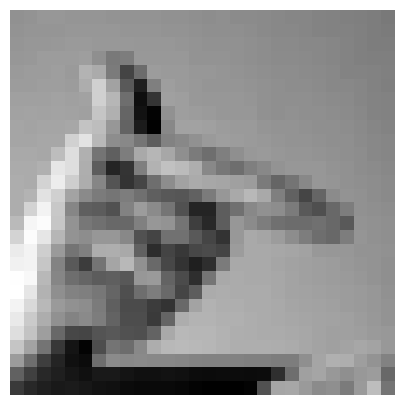

In [15]:
# Select a random index from the test set
rnd_idx = np.random.randint(len(y_test)) # Generate a random integer between 0 and the length of y_test

# Assign the labels from the dataset
label_to_sign = {0: 'A',
                 1: 'B',
                 2: 'C',
                 3: 'D',
                 4: 'E',
                 5: 'F',
                 6: 'G',
                 7: 'H',
                 8: 'I',
                 9: 'K',
                 10: 'L',
                 11: 'M',
                 12: 'N',
                 13: 'O',
                 14: 'P',
                 15: 'Q',
                 16: 'R',
                 17: 'S',
                 18: 'T',
                 19: 'U',
                 20: 'V',
                 21: 'W',
                 22: 'X',
                 23: 'Y',
                 24: 'Y'}  # Excluding 'J' and 'Z'
print(f'The image represents the sign: {label_to_sign[y_test[rnd_idx]]}')
print(f'The value represents the sign: {y_test[rnd_idx]}')

# Reshape and plot the selected test image
plot_number(x_test[rnd_idx].reshape(28,28))

### Equations provided for our model

$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$


$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$

$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$

$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Create mini batches

The following section divides the section into smaller subsets called **mini-batches.**

They make the training process faster and more effective at learning from the dataset.

In [16]:
def create_minibatches(mb_size, x, y, shuffle=True):
    '''
    Creates minibatches from the dataset.

    Parameters:
        mb_size (int): The size of each minibatch.
        x (np.ndarray): Input data of shape (num_samples, num_features).
        y (np.ndarray): Labels of shape (num_samples) from the input data.
        shuffle (bool): Whether to shuffle the data before creating minibatches. Default is True.
    '''
    assert x.shape[0] == y.shape[0], 'Mismatch minibatch size'

    # Total number of samples in the dataset
    total_data = x.shape[0]

    if shuffle:
      # Create an array of indices [0, 1, 2, ..., total_data-1]
      idxs = np.arange(total_data)
      # Randomly shuffle the indices to randomize the order of the data
      np.random.shuffle(idxs)
      # Reorder `x` based on the shuffled indices
      x = x[idxs]
      # Reorder `y` based on the shuffled indices
      y = y[idxs]

    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [17]:
for i, (x, y) in enumerate(create_minibatches(128,x_train, y_train)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


## PyTorch Section

In [18]:
# Convert the training, validation and test datatsets from NumPy arrays to PyTorch sensors.
# Create a copy - avoid modifying the original datasets

# Training set
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

# Validation set
x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

# Test set
x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

### Use GPUs

To check if a GPU is available, if not, use a CPU.

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Calculate accuracy

Accuracy is a metric that measures the proportion of correctly classified instances out of the total number of instances.

In [33]:
def accuracy(model, x, y, mb_size):
    """
    This function evaluates the performance of the trained model on a dataset (x ,y).

    Parameters:
    model: A PyTorch model object.
    x: Input features.
    y: Target labels.
    mb_size: Batch size for mini-batch processing.
    """
    num_correct = 0
    num_total = 0
    cost = 0.
    # Set the model to evaluation mode
    model.eval()
    # Move the model to the specified device
    model = model.to(device=device)
    # Disable gradient calculation during the evaluation process
    with torch.no_grad():
        # xi : input data (images)
        # yi : labels or targets
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x, y),1):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            # Feed the input features to the `model` for prediction
            scores = model(xi)
            # Cross-entropy loss function to calculate the loss of the model's prediction
            cost += (F.cross_entropy(scores, yi)).item() # `.item()` is used to extract the scalar value of the loss
            # Extract the predicted labels from the scores
            _, pred = scores.max(dim=1) # find the highest score along dimension '1'
            num_correct += (pred == yi.squeeze()).sum()
            num_total += pred.size(0)

        return cost/mb, float(num_correct)/num_total

### Training Loop

Define the training process for the model.

The `train` function is responsible for training the PyTorch model.

It iterates through the data in epochs and mini-batches, makes predictions, calculates the loss, and updates the model's parameters to minimize the loss, improving its accuracy in recognizing ASL signs.

In [34]:
def train(model, optimiser, mb_size, epochs=100):
    """
    This function trains a PyTorch model using the provided optimizer and data.

    Parameters:
    model: A PyTorch model object.
    optimiser: An optimizer object.
    mb_size: Batch size for mini-batch processing.
    epochs: Number of training epochs.
    """

    # Initialization
    model = model.to(device=device)
    train_cost = 0.
    val_cost = 0.
    for epoch in range(epochs):
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x_train_tensor, y_train_tensor), 1):
            model.train()
            # xi : input data (images)
            # yi : labels or targets
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            # The model makes predictions
            scores = model(xi)
            # Calculate the loss or cost function using cross-entropy
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            # Reset the gradients to zero before calculate new gradients
            optimiser.zero_grad()
            # Calculate the gradients of the loss function using backpropagation
            cost.backward()
            # Update parameters
            optimiser.step()

            train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()
            train_total += scores.size(0)
            train_cost_acum += cost.item()

        val_cost, val_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/mb
        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Train Cost: {train_cost:.4f} | Val Cost: {val_cost:.4f} |'
                      f' Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f} |'
                      f' Learning Rate: {optimiser.param_groups[0]["lr"]:.5f}')

### Sequential Linear


Define a sequential neural network with hidden layers, set hyperparameters for training, and initializes an optimizer to update the weights during training.

In [35]:
# hidden1 = 100
hidden = 200
lr = 1e-3
epochs = 100
mb_size = 128

# Define the structure of the neural network
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden),
                       nn.Dropout(), # Regularization technique to prevent overfitting
                       nn.ReLU(), # Activation function - replaces any negative input values with 0
                      # nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))

# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)

# Adam algorithm - update the weights of a NN during training
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
# Set up a learning rate scheduler - adjust the LR during training to further improve performance
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch: 0 | Train Cost: 0.8697 | Val Cost: 0.7746 | Train Accuracy: 0.7257 | Val Accuracy: 0.7736 | Learning Rate: 0.00400
Epoch: 10 | Train Cost: 0.1779 | Val Cost: 1.5094 | Train Accuracy: 0.9543 | Val Accuracy: 0.7895 | Learning Rate: 0.00400
Epoch: 20 | Train Cost: 0.1530 | Val Cost: 2.0130 | Train Accuracy: 0.9654 | Val Accuracy: 0.7817 | Learning Rate: 0.00400
Epoch: 30 | Train Cost: 0.2073 | Val Cost: 1.8511 | Train Accuracy: 0.9609 | Val Accuracy: 0.8009 | Learning Rate: 0.00400
Epoch: 40 | Train Cost: 0.1535 | Val Cost: 2.9040 | Train Accuracy: 0.9701 | Val Accuracy: 0.7942 | Learning Rate: 0.00400
Epoch: 50 | Train Cost: 0.1874 | Val Cost: 2.5447 | Train Accuracy: 0.9641 | Val Accuracy: 0.7987 | Learning Rate: 0.00400
Epoch: 60 | Train Cost: 0.1662 | Val Cost: 2.7412 | Train Accuracy: 0.9679 | Val Accuracy: 0.8017 | Learning Rate: 0.00400
Epoch: 70 | Train Cost: 0.1616 | Val Cost: 2.7735 | Train Accuracy: 0.9701 | Val Accuracy: 0.7892 | Learning Rate: 0.00400
Epoch: 80 | Train

In [36]:
# Highest accuracy value
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)[1]

0.7986614612381484

In [37]:
def predict(x, model):
    """
    This function makes predictions using a trained PyTorch model.

    Parameters:
    x: Input features.
    model: A trained PyTorch model object.
    """
    x = x.to(device=device, dtype = torch.float32)
    scores = model(x) # mb_size, 10
    # Extracts the predicted label from the `scores`
    _, pred = scores.max(dim=1) #pred shape (mb_size )
    return pred

The image represents the letter: g


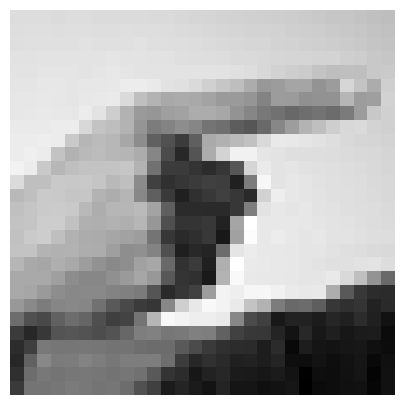

The predicted value is: g


In [41]:
rnd_idx = np.random.randint(len(y_test))
print(f'The image represents the letter: {alphabet[y_test[rnd_idx]]}')
plot_number(x_test[rnd_idx].reshape(28,28))
pred = predict(x_test_tensor[rnd_idx].reshape(1, -1), model1)
print(f'The predicted value is: {alphabet[pred]}')